# Gold ETF Price Prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# Interpolation
from scipy.interpolate import interp1d

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
# pip install yfinance
import yfinance as yf
import quandl


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,

# Data Collection

In [2]:
# GLD - Gold ETF by SPDR
ETFdata = yf.download('GLD', '2010-01-01', '2021-05-20', auto_adjust=True)
ETFdata = ETFdata.rename(columns={"Close": "GLD"})
# SLV - Silver ETF
SLV = yf.download('SLV', '2010-01-01', '2021-05-20', auto_adjust=True)
SLV = SLV.rename(columns={"Close": "SLV"})
# USO - Crude Oil ETF
USO = yf.download('USO', '2010-01-01', '2021-05-20', auto_adjust=True)
USO = USO.rename(columns={"Close": "USO"})
# S&P 500 Index
SP500 = yf.download('^GSPC', '2010-01-01', '2021-05-20', auto_adjust=True)
SP500 = SP500.rename(columns={"Close": "SP500"})
# Source - World Gold Council
Spot = pd.read_excel("GoldSpotPrices.xlsx", index_col=None, dtype={'Date': str, 'Spot': float}) 
#Economic data
US_CPI = quandl.get("RATEINF/CPI_USA", start_date="2009-12-01", end_date="2021-05-20") # Monthly
US_CPI = US_CPI.rename(columns={"Value": "CPI"})
US_GDP_Real = quandl.get("FRED/GDPPOT", start_date="2010-01-01", end_date="2021-05-20") # Quarterly
US_GDP_Real = US_GDP_Real.rename(columns={"Value": "Real_GDP"})
US_10YR_Rate = quandl.get("FRED/WGS10YR", start_date="2010-01-01", end_date="2021-05-20")  # Weekly
US_10YR_Rate = US_10YR_Rate.rename(columns={"Value": "10YR_Rate"})
# USD Index
USDIndex = yf.download('DX-Y.NYB', '2010-01-01', '2021-05-20', auto_adjust=True)
USDIndex = USDIndex.rename(columns={"Close": "USD_Index"})
# Supply demand data - Quarterly
Gold_SD = pd.read_excel("Gold_SupplyDemand.xlsx", index_col=None, dtype={'Date': str, 'Gold_Demand': float, 'Gold_Supply': float}) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Data Cleaning

In [3]:
def convert_Quarter_to_date(name):
    data = name.split("'")
    if data[0] == "Q1":
        return_value = "20" + data[1] + "-03-31"
    elif data[0] == "Q2":
        return_value =  "20" + data[1] + "-06-30"
    elif data[0] == "Q3":
        return_value =  "20" + data[1] + "-09-30"
    elif data[0] == "Q4":
        return_value =  "20" + data[1] + "-12-31"

    return return_value

Gold_SD.Date = Gold_SD.Date.apply(lambda x: convert_Quarter_to_date(x))

# interpolate to daily frequency data
rng = pd.date_range('2009-12-31', '2021-05-20', freq = 'D')
US_GDP_Real = US_GDP_Real.reindex(rng).interpolate(axis=0)
US_CPI = US_CPI.reindex(rng).interpolate(axis=0)
US_10YR_Rate = US_10YR_Rate.reindex(rng).interpolate(axis=0)
Gold_SD.index = pd.DatetimeIndex(Gold_SD.Date)
Gold_SD = Gold_SD.reindex(rng).interpolate(axis=0)
Spot.index = pd.DatetimeIndex(Spot.Date)

In [4]:
# Final data
data = pd.concat([ETFdata, Spot, SLV, USO, SP500, US_CPI, US_GDP_Real, US_10YR_Rate, USDIndex, Gold_SD], axis = 1, join='outer')[['Spot','GLD', 'SLV', 'USO', 'SP500', 'CPI', 'Real_GDP', '10YR_Rate', 'USD_Index', 'Gold_Demand', 'Gold_Supply']]

# Data Analysis

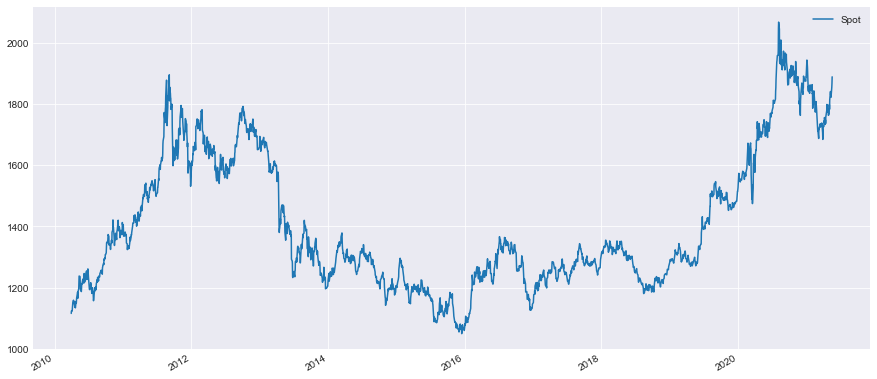

In [25]:
data[['Spot']].plot(figsize=(15,7))

In [5]:
corr = data.corr()
corr.style.background_gradient().set_precision(2)

,Spot,GLD,SLV,USO,SP500,CPI,Real_GDP,10YR_Rate,USD_Index,Gold_Demand,Gold_Supply
Spot,1.00,1.00,0.64,-0.04,0.23,0.25,0.19,-0.63,-0.24,-0.17,-0.19
GLD,1.00,1.00,0.70,0.05,0.14,0.17,0.10,-0.59,-0.32,-0.12,-0.26
SLV,0.64,0.70,1.00,0.59,-0.45,-0.45,-0.52,-0.02,-0.75,0.18,-0.65
USO,-0.04,0.05,0.59,1.00,-0.85,-0.85,-0.91,0.53,-0.91,0.44,-0.80
SP500,0.23,0.14,-0.45,-0.85,1.00,0.97,0.97,-0.48,0.70,-0.60,0.78
CPI,0.25,0.17,-0.45,-0.85,0.97,1.00,0.99,-0.53,0.72,-0.48,0.80
Real_GDP,0.19,0.10,-0.52,-0.91,0.97,0.99,1.00,-0.53,0.79,-0.49,0.82
10YR_Rate,-0.63,-0.59,-0.02,0.53,-0.48,-0.53,-0.53,1.00,-0.38,0.23,-0.27
USD_Index,-0.24,-0.32,-0.75,-0.91,0.70,0.72,0.79,-0.38,1.00,-0.27,0.77
Gold_Demand,-0.17,-0.12,0.18,0.44,-0.60,-0.48,-0.49,0.23,-0.27,1.00,-0.30


In [6]:
data['next_day_price'] = data.Spot.shift(-1)
data = data.dropna()

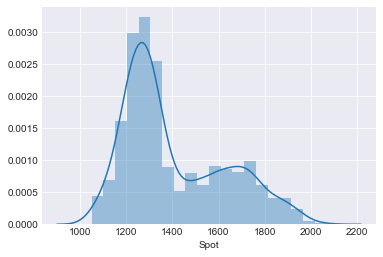

In [7]:
sns.distplot(data['Spot'])

Distribution of Spot prices shows it is left skewed. This behaviour is expected as the prices have been at all time high in the recent times, causing the data to cluster more near lower prices on the left.

In [54]:
X = data[['GLD', 'USO', 'SP500', 'Real_GDP', 'CPI', '10YR_Rate', 'USD_Index', 'Gold_Demand', 'Gold_Supply']]
y = data['next_day_price']

Adding silver prices causes reduction in adjusted r-squared value and increase in AIC. Thus removing from dependent variables used for prediction. 

In [55]:
# Split data into training, testing and validation set

t = 0.6 # 60% training data
test = 0.2 # 20% test data
v = 0.2 # 20% Validation data
t = int(t*len(data))
test = t + int(test*len(data))
v = test + int(v*len(data))

# Training data set
X_train = X[:t]
y_train = y[:t]

# Test data set
X_test = X[t:test]
y_test = y[t:test]

# Validation data set
X_valid = X[test:v]
y_valid = y[test:v]

In [56]:
# Linear regression model
linear = LinearRegression().fit(X_train, y_train)

# Gold Price Prediction using linear regression
predicted_price = linear.predict(X_test)

In [57]:
regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

17250.340976083437


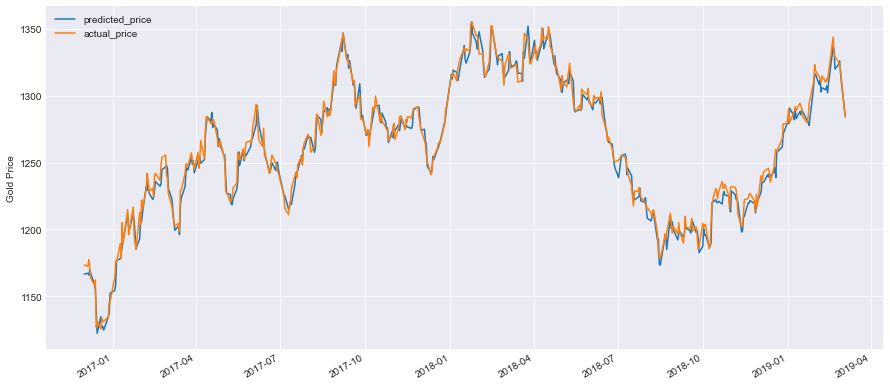

In [52]:
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(15, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

In [53]:
r2_score = linear.score(X[t:test], y[t:test])*100
print("r-squared: ",float("{0:.2f}".format(r2_score)))
print("adjusted r-squared: ",float("{0:.2f}".format((1 - (1-linear.score(X[t:test], y[t:test]))*(len(y[t:test])-1)/(len(y[t:test])-X[t:test].shape[1]-1))*100)))

r-squared:  98.22
adjusted r-squared:  98.18


In [14]:
y_train_data_pred = linear.predict(X_train)
fold_training_error = mean_absolute_error(y_train, y_train_data_pred) 
fold_testing_error = mean_absolute_error(y_test, predicted_price.price)
print("Training MAE: %.3f" %fold_training_error)
print("Testing MAE: %.3f" %fold_testing_error)

print("Training MSE: %.3f" %mean_squared_error(y_train, y_train_data_pred))
print("Testing MSE: %.3f" %mean_squared_error(y_test, predicted_price.price))

rmspe = (np.sqrt(np.mean(np.square((y_test - predicted_price.price) / y_test)))) * 100
print("%.2f %%" %rmspe)

Training MAE: 8.471
Testing MAE: 5.107
Training MSE: 139.234
Testing MSE: 43.294
0.52 %


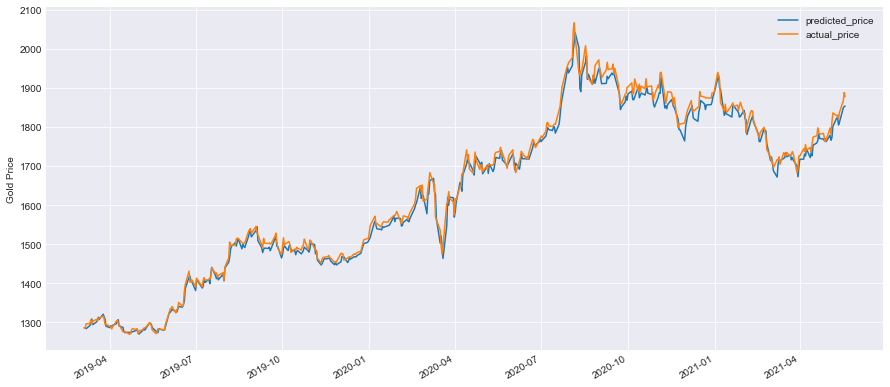

In [28]:
# Validation data test
pred_valid_price = linear.predict(X_valid)

pred_valid_price = pd.DataFrame(pred_valid_price, index=y_valid.index, columns=['price'])
pred_valid_price.plot(figsize=(15, 7))
y_valid.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

In [30]:
# Validation data
r2_score = linear.score(X[test:v], y[test:v])*100
print("r-squared: ",float("{0:.2f}".format(r2_score)))
print("adjusted r-squared: ",float("{0:.2f}".format((1 - (1-linear.score(X[test:v], y[test:v]))*(len(y[test:v])-1)/(len(y[test:v])-X[test:v].shape[1]-1))*100)))

r-squared:  99.3
adjusted r-squared:  99.28
